# Jax Quickstart

本文目的主要是简单上手JAX以开始学习了解。

JAX的安装暂时还没有 PyTorch，Tensorflow那么方便，还需要自己手动安装好 CUDA 和 CuDNN 才能支持GPU 运算，由于本repo暂时在笔记本电脑上学习，所以暂时只安装CPU版本。安装通过以下命令即可：

```Shell
pip install --upgrade pip
pip install --upgrade jax jaxlib  # CPU-only version
```

JAX目前只支持Linux和Mac，所以windows下要么在 win10 的Ubuntu下执行，要么从source直接build，目前本repo下采用前者策略。

参考:

- [JAX Quickstart](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html)

**JAX is NumPy on the CPU, GPU, and TPU, with great automatic differentiation for high-performance machine learning research.**

JAX是一个基于Numpy的，整合了[Autograd](https://github.com/hips/autograd) 和 [XLA](https://www.tensorflow.org/xla)的，有着优秀自动微分计算能力的高性能机器学习研究库。

使用它的 Autograd，JAX 能够自动微分 native Python和 NumPy代码。可以说是非常（优）秀了。它能在Python的大部分功能（包括循环，if，递归和闭包）上进行微分运算，还能计算微分的微分。它支持反向模式和正向模式微分，并且两者可以任意组合为任意顺序。

JAX还能使用 XLA 在诸如GPU和TPU的加速器上编译和运行NumPy代码。默认情况下，编译是在后台进行的，库调用得到及时的编译和执行。但是JAX允许使用one-function API, jit，即时将自己的Python函数编译为XLA优化的内核。编译和自动微分可以任意组合，因此无需离开Python即可表达复杂的算法并获得最佳性能。

针对自动向量化的vmap和针对single-program multiple-data (SPMD) 多加速器并行编程的pmap，连同 grad 和 jit 一起，组成了JAX的composable function transformations。

In [1]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

## Multiplying Matrices

在以下示例中，生成随机数据。NumPy和JAX之间的一大区别是生成随机数的方式。有关更多详细信息，后续intro部分有介绍。

In [2]:
key = random.PRNGKey(0)
x = random.normal(key, (10,))
print(x)

[-0.372111    0.2642311  -0.18252774 -0.7368198  -0.44030386 -0.15214427
 -0.6713536  -0.59086424  0.73168874  0.56730247]


让我们更深入一点，乘以两个大矩阵。

In [3]:
size = 3000
x = random.normal(key, (size, size), dtype=jnp.float32)
%timeit jnp.dot(x, x.T).block_until_ready()

264 ms ± 46.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


增加block_until_ready是因为默认情况下JAX使用异步执行（请参见[异步调度](https://jax.readthedocs.io/en/latest/async_dispatch.html#async-dispatch)）。

JAX NumPy函数可在常规NumPy数组上使用。

In [4]:
import numpy as np
x = np.random.normal(size=(size, size)).astype(np.float32)
%timeit jnp.dot(x, x.T).block_until_ready()

315 ms ± 31.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


这里是CPU下运行的，如果加载到GPU就会比较慢，因为每次都必须将数据传输到GPU。

使用device_put()来确保NDArray由设备内存支持。

In [5]:
from jax import device_put

x = np.random.normal(size=(size, size)).astype(np.float32)
x = device_put(x)
%timeit jnp.dot(x, x.T).block_until_ready()

262 ms ± 25.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


device_put()的输出仍然像NDArray一样，仅在需要打印，绘图，保存到磁盘，分支等需要它们的值时才将值复制回CPU。device_put()的行为等效于函数jit(lambda x: x)，但是速度更快。

如果有GPU（或TPU！），这些调用将在加速器上运行，并且可能比在CPU上快得多。

In [6]:
x = np.random.normal(size=(size, size)).astype(np.float32)
%timeit np.dot(x, x.T)

198 ms ± 6.57 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


JAX不仅仅是一个能由GPU支持（虽然我们这里只是在CPU上，但是如果安装的是GPU版本的是能够支持的）的NumPy。它还带有一些程序转换，这些转换在编写数值代码时很有用。目前，主要有三个：

- jit()，以加快代码
- grad()，用于计算导数
- vmap()，用于自动矢量化或批处理。

让我们一一介绍并最终以有趣的方式编写这些内容。

## 利用jit()加速函数

JAX在GPU上透明运行（如果没有，则在CPU上运行，TPU即将推出！）。但是，在上面的示例中，JAX一次将内核分配给GPU的一次运算。如果有一系列运算，则可以使用@jit装饰器以使用XLA一起编译。

In [7]:
def selu(x, alpha=1.67, lmbda=1.05):
    return lmbda * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

x = random.normal(key, (1000000,))
%timeit selu(x).block_until_ready()

7.89 ms ± 108 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


我们可以使用@jit加快速度，它将在第一次selu调用时实现jit-compile，并在之后缓存。

In [8]:
selu_jit = jit(selu)
%timeit selu_jit(x).block_until_ready()

1.25 ms ± 45.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


可以看到CPU上也能轻松实现加速，GPU上可能能加速更多了。

## grad() 求导

除了评估数值函数外，我们还希望对其进行转换。一种转换是自动微分。在JAX中，就像在[Autograd](https://github.com/HIPS/autograd)中一样，可以使用grad()函数来计算梯度。

In [9]:
def sum_logistic(x):
    return jnp.sum(1.0 / (1.0 + jnp.exp(-x)))

x_small = jnp.arange(3.)
derivative_fn = grad(sum_logistic)
print(derivative_fn(x_small))

[0.25       0.19661197 0.10499357]


让我们以有限差分验证我们的结果是正确的。

In [10]:
def first_finite_differences(f, x):
    eps = 1e-3
    return jnp.array([(f(x + eps * v) - f(x - eps * v)) / (2 * eps) for v in jnp.eye(len(x))])

print(first_finite_differences(sum_logistic, x_small))

[0.24998187 0.1964569  0.10502338]


取导数就是直接grad()这么容易。grad()和jit()可以任意混合：

In [11]:
print(grad(jit(grad(jit(grad(sum_logistic)))))(1.0))

-0.035325594


对于更高级的autodiff，可以将jax.vjp()用于反向模式 矢量-雅各比积 和jax.jvp()正向模式 雅可比-矢量 积。两者可以彼此任意组合，也可以与其他JAX转换任意组合。这是组合它们以构成有效计算完整的Hessian矩阵的函数的一种方法：

In [12]:
from jax import jacfwd, jacrev
def hessian(fun):
    return jit(jacfwd(jacrev(fun)))

## 自动向量化 vmap()

JAX API中还有另一种转换比较有用：vmap()向量化映射。它具有沿数组轴映射函数的语义，但不是将循环保留在外部，而是将循环推入函数的原始运算中以提高性能。当与jit()组合时，它的速度可以与手动添加批处理维度一样快。

一个简单的示例，使用vmap()将矩阵-向量乘积提升为矩阵-矩阵乘积。尽管在这种特定情况下很容易手动完成此运算，但是相同的技术可以应用于更复杂的功能。

In [13]:
mat = random.normal(key, (150, 100))
batched_x = random.normal(key, (10, 100))

def apply_matrix(v):
    return jnp.dot(mat, v)

给定诸如apply_matrix之类的功能，我们可以在Python中循环执行批处理维度，但是这样做的性能通常很差。

In [14]:
def naively_batched_apply_matrix(v_batched):
    return jnp.stack([apply_matrix(v) for v in v_batched])

print('Naively batched')
%timeit naively_batched_apply_matrix(batched_x).block_until_ready()

Naively batched
5.7 ms ± 610 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


我们知道如何手动批处理。在这种情况下，jnp.dot透明地处理额外的批次维度。

In [15]:
@jit
def batched_apply_matrix(v_batched):
    return jnp.dot(v_batched, mat.T)

print('Manually batched')
%timeit batched_apply_matrix(batched_x).block_until_ready()

Manually batched
265 µs ± 57.7 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


但是，假设没有批处理支持，我们的功能更加复杂。我们可以用来vmap()自动添加批处理支持。

In [16]:
@jit
def vmap_batched_apply_matrix(v_batched):
    return vmap(apply_matrix)(v_batched)

print('Auto-vectorized with vmap')
%timeit vmap_batched_apply_matrix(batched_x).block_until_ready()

Auto-vectorized with vmap
268 µs ± 63.2 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


当然，vmap()可以与jit()，grad()和任何其它JAX变换任意组合。

这只是JAX可以做的一部分事情，更多内容后续逐渐补充。

接下来看看如何在JAX的框架中思考问题。

JAX提供了一个简单而强大的API来编写加速的数值代码，但是在JAX中有效地工作有时需要额外考虑一些东西。接下来更加全面地了解JAX的运行方式，方便后续更有效地使用它。

## JAX与NumPy

关键概念：

- 为了方便起见，JAX提供了受NumPy启发的接口。
- 通过[duck-typing](https://en.wikipedia.org/wiki/Duck_typing)，JAX数组通常可以直接替换NumPy数组。
- 与NumPy数组不同，JAX数组始终是不可变的。

NumPy提供了众所周知的，功能强大的API，用于处理数值数据。为了方便起见，JAX提供了与numpy API非常相似的jax.numpy镜像，能够帮助大家轻松进入JAX。几乎所有numpy可以完成的工作都可以通过jax.numpy完成：

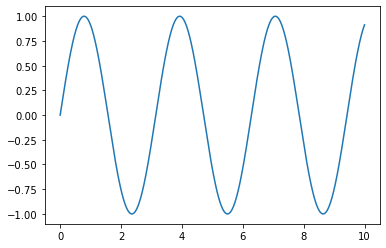

In [17]:
import matplotlib.pyplot as plt
import numpy as np

x_np = np.linspace(0, 10, 1000)
y_np = 2 * np.sin(x_np) * np.cos(x_np)
plt.plot(x_np, y_np)

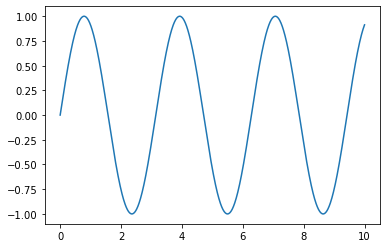

In [18]:
import jax.numpy as jnp

x_jnp = jnp.linspace(0, 10, 1000)
y_jnp = 2 * jnp.sin(x_jnp) * jnp.cos(x_jnp)
plt.plot(x_jnp, y_jnp);

除了np和jnp，代码是相同的，结果也是相同的。正如所看到的这样，JAX数组通常可以代替NumPy数组用于绘图等。

数组本身实现为不同的Python类型：

In [19]:
type(x_np)

numpy.ndarray

In [20]:
type(x_jnp)

jaxlib.xla_extension.DeviceArray

Python的Duck typing允许JAX数组和NumPy数组在许多地方互换使用。

但是，JAX和NumPy数组之间有一个重要的区别：JAX数组是不可变的，这意味着一旦创建，它们的内容就无法更改。

而NumPy中数组是可以更改的：

In [22]:
# NumPy: mutable arrays
x = np.arange(10)
x[0] = 10
print(x)

[10  1  2  3  4  5  6  7  8  9]


JAX中的同样的运算会导致错误，因为JAX数组是不可变的：

In [23]:
# JAX: immutable arrays
x = jnp.arange(10)
x[0] = 10

TypeError: '<class 'jaxlib.xla_extension.DeviceArray'>' object does not support item assignment. JAX arrays are immutable; perhaps you want jax.ops.index_update or jax.ops.index_add instead?

为了更新单个元素，JAX提供了索引更新语法[indexed update syntax](https://jax.readthedocs.io/en/latest/jax.ops.html#syntactic-sugar-for-indexed-update-operators)，该语法返回更新后的副本：

In [24]:
y = x.at[0].set(10)
print(x)
print(y)

[0 1 2 3 4 5 6 7 8 9]
[10  1  2  3  4  5  6  7  8  9]


## NumPy，Lax和XLA：JAX API layering

关键概念：

- jax.numpy 是提供大家熟悉的接口的高级包装器。
- jax.lax 是更严格且通常表现更强大的更底层API。
- 所有JAX运算都是根据XLA（加速线性代数编译器）中的运算实现的。

如果看一看jax.numpy的来源，就会发现所有运算最终都是根据jax.lax中定义的函数来表示的。可以认为jax.lax是用于处理多维数组的更严格但通常更强大的API。

例如，虽然jax.numpy将隐式提升参数以允许在混合数据类型之间进行运算，但jax.lax不会：

In [25]:
import jax.numpy as jnp
jnp.add(1, 1.0)  # jax.numpy API implicitly promotes mixed types.

DeviceArray(2., dtype=float32)

In [26]:
from jax import lax
lax.add(1, 1.0)  # jax.lax API requires explicit type promotion.

TypeError: add requires arguments to have the same dtypes, got int32, float32.

如果直接使用jax.lax，则必须显式进行类型升级：

In [27]:
lax.add(jnp.float32(1), 1.0)

DeviceArray(2., dtype=float32)

除了这种严格性，jax.lax还为NumPy支持的更多常规运算提供了有效的API。

例如，考虑一维卷积，可以用这种方式在NumPy中表示：

In [28]:
x = jnp.array([1, 2, 1])
y = jnp.ones(10)
jnp.convolve(x, y)

DeviceArray([1., 3., 4., 4., 4., 4., 4., 4., 4., 4., 3., 1.], dtype=float32)

通过lax.conv_general_dilated，此NumPy运算被转换为更通用的卷积：

In [29]:
from jax import lax
result = lax.conv_general_dilated(
    x.reshape(1, 1, 3).astype(float),  # note: explicit promotion
    y.reshape(1, 1, 10),
    window_strides=(1,),
    padding=[(len(y) - 1, len(y) - 1)])  # equivalent of padding='full' in NumPy
result[0, 0]

DeviceArray([1., 3., 4., 4., 4., 4., 4., 4., 4., 4., 3., 1.], dtype=float32)

这是一个批处理卷积运算，旨在有效地处理深度神经网络中经常使用的卷积类型。它需要更多样板文件，但比NumPy提供的卷积要灵活得多（可扩展性更多）（有关JAX卷积的更多详细信息，请参见[Convolutions in JAX](https://jax.readthedocs.io/en/latest/notebooks/convolutions.html)）。

从本质上讲，所有jax.lax运算都是XLA中运算的Python包装器。例如，在这里，卷积实现由[XLA：ConvWithGeneralPadding](https://www.tensorflow.org/xla/operation_semantics#convwithgeneralpadding_convolution)提供。最终，每个JAX运算都用这些基本XLA运算来表示，这就是启用即时（JIT）编译的原因。

## To JIT or not to JIT

先稍微补充一点JIT的基本概念，主要参考了[这里](https://www.cs.cornell.edu/courses/cs6120/2020fa/blog/tracemonkey/)。

Just-in-time compilation is a technique in which code is compiled into machine code while it is being executed, rather than being compiled upfront (e.g., C/GCC) or interpreted directly (e.g., Python/CPython). 简而言之，就是 一种在程序执行时 将 程序编译为机器码的技术，和python解释器不同。

在函数接收数据时，python是直到运行的时候才知道数据的类型的，所以即时编译有的策略是检查函数最常用的数据类型，然后提前编译好类型；另一种方式就是 trace-based JIT compiler，它通过程序检测热跟踪，这些热跟踪是跨分支和函数调用的字节码指令的线性序列。这里主要稍微了解下trace，因为后面这个词还会出现，自己理解，trace应该就是指对函数的一系列运算的检测。上面提到的“热跟踪”的热就是能判断出来哪部分的运算最频繁，比如循环。

关键概念：

- 默认情况下，JAX一次执行一运算，顺序执行。
- 使用即时编译（JIT）装饰器，可以优化运算序列并快速运行。
- 并非所有的JAX代码都可以JIT编译，因为它要求数组形状是静态的并且在编译时是已知的。

所有JAX运算均以XLA表示，所以JAX可以使用XLA编译器非常有效地执行代码块。

例如，考虑以下函数，该函数对2D矩阵的行进行归一化，以jax.numpy运算表示：

In [30]:
import jax.numpy as jnp

def norm(X):
    X = X - X.mean(0)
    return X / X.std(0)

可以使用以下jax.jit转换来创建函数的即时编译版本：

In [31]:
from jax import jit
norm_compiled = jit(norm)

此函数返回的结果与原始结果相同，能达到标准浮点精度：

In [32]:
np.random.seed(1701)
X = jnp.array(np.random.rand(10000, 10))
np.allclose(norm(X), norm_compiled(X), atol=1E-6)

True

但是由于编译（包括运算的融合，避免分配临时数组以及许多其他技巧），在JIT编译的情况下，执行时间可以快几个数量级（请注意，使用block_until_ready()来解决JAX的异步派发）：

In [33]:
%timeit norm(X).block_until_ready()
%timeit norm_compiled(X).block_until_ready()

3.99 ms ± 172 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
371 µs ± 11.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


jax.jit确实有局限性：特别是，它要求所有数组都具有静态形状。这意味着某些JAX运算与JIT编译不兼容。

例如，可以在逐个运算模式下执行它：

In [34]:
def get_negatives(x):
    return x[x < 0]

x = jnp.array(np.random.randn(10))
get_negatives(x)

DeviceArray([-0.10570311, -0.59403396, -0.8680282 , -0.23489487], dtype=float32)

但是，如果尝试在jit模式下执行它，它将返回一个错误：

In [35]:
jit(get_negatives)(x)

NonConcreteBooleanIndexError: Array boolean indices must be concrete; got ShapedArray(bool[10])
 (https://jax.readthedocs.io/en/latest/errors.html#jax.errors.NonConcreteBooleanIndexError)

这是因为该函数生成一个在编译时形状未知的数组：输出的大小取决于输入数组的值，因此它与JIT不兼容。

## JIT机制：tracing 及static 变量

关键概念：

- JIT和其他JAX转换通过tracing函数以确定其对特定形状和类型的输入的影响。
- 不需要跟踪的变量可以标记为静态

要jax.jit有效使用，了解它是如何工作的很有用。在JIT编译的函数中放入一些print()语句，然后调用该函数：

In [36]:
@jit
def f(x, y):
    print("Running f():")
    print(f"  x = {x}")
    print(f"  y = {y}")
    result = jnp.dot(x + 1, y + 1)
    print(f"  result = {result}")
    return result

x = np.random.randn(3, 4)
y = np.random.randn(4)
f(x, y)

Running f():
  x = Traced<ShapedArray(float32[3,4])>with<DynamicJaxprTrace(level=0/1)>
  y = Traced<ShapedArray(float32[4])>with<DynamicJaxprTrace(level=0/1)>
  result = Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=0/1)>


DeviceArray([0.25773212, 5.3623195 , 5.4032435 ], dtype=float32)

注意，虽然执行了打印语句，但并没有打印我们传递给函数的数据，而是打印了代表它们的tracer跟踪器对象。

这些tracer对象是jax.jit用来提取函数指定的运算序列的对象。基本tracers是可对数组的形状和dtype进行编码的，但与值无关。并且可以在XLA内有效地将此记录的计算序列应用于具有相同形状和dtype的新输入，而不必重新执行Python代码。

当我们再次在匹配的输入上调用已编译的函数时，不需要重新编译，所以也不会打印任何内容，因为结果是在已编译的XLA中而不是在Python中计算的：

In [37]:
x2 = np.random.randn(3, 4)
y2 = np.random.randn(4)
f(x2, y2)

DeviceArray([1.4344584, 4.3004413, 7.9897013], dtype=float32)

提取的运算序列以JAX表达式（简称jaxpr）编码。可以使用jax.make_jaxpr转换查看jaxpr：

In [38]:
from jax import make_jaxpr

def f(x, y):
    return jnp.dot(x + 1, y + 1)

make_jaxpr(f)(x, y)

{ lambda  ; a b.
  let c = add a 1.0
      d = add b 1.0
      e = dot_general[ dimension_numbers=(((1,), (0,)), ((), ()))
                       precision=None
                       preferred_element_type=None ] c d
  in (e,) }

注意一种结果：由于JIT编译是在没有数组内容信息的情况下完成的，因此函数中的**控制流语句不能依赖于被traced的值**。例如，这样是失败的：

In [41]:
@jit
def f(x, neg):
    return -x if neg else x
f(1, True)

ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: Traced<ShapedArray(bool[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>
The problem arose with the `bool` function. 
While tracing the function f at <ipython-input-41-aea367767056>:1, transformed by jit., this concrete value was not available in Python because it depends on the value of the arguments to f at <ipython-input-41-aea367767056>:1, transformed by jit. at flattened positions [1], and the computation of these values is being staged out (that is, delayed rather than executed eagerly).
 (https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError)

如果存在不希望tracing变量，则出于JIT编译的目的，可以将它们标记为静态变量：

In [42]:
from functools import partial

@partial(jit, static_argnums=(1,))
def f(x, neg):
    return -x if neg else x
f(1, True)

DeviceArray(-1, dtype=int32)

请注意，使用不同的静态参数调用JIT编译的函数会导致重新编译，因此该函数仍可按预期工作：

In [43]:
f(1, False)

DeviceArray(1, dtype=int32)

理解哪些值和运算将是静态的以及被跟踪的是jax.jit有效使用的关键部分。

## 静态与跟踪运算

关键概念：

- 正如值可以是静态的或跟踪的一样，运算也可以是静态的或tracing的。
- 静态运算是在Python编译时评估的；tracing的运算在XLA中在运行时进行编译和评估。
- 为静态的运算使用numpy; 要被traced的运算使用jax.numpy。

静态值和traced值之间的区别使得考虑如何使静态值保持静态非常重要。考虑以下功能：

In [44]:
import jax.numpy as jnp
from jax import jit

@jit
def f(x):
    return x.reshape(jnp.array(x.shape).prod())

x = jnp.ones((2, 3))
f(x)

TypeError: Shapes must be 1D sequences of concrete values of integer type, got [Traced<ShapedArray(int32[])>with<DynamicJaxprTrace(level=0/1)>].
If using `jit`, try using `static_argnums` or applying `jit` to smaller subfunctions.

失败，并显示一条错误，指出 jax.numpy.reshape 中找到了tracer。让我们在函数中添加一些打印语句，以了解发生这种情况的原因：

In [45]:
@jit
def f(x):
    print(f"x = {x}")
    print(f"x.shape = {x.shape}")
    print(f"jnp.array(x.shape).prod() = {jnp.array(x.shape).prod()}")
    # comment this out to avoid the error:
    # return x.reshape(jnp.array(x.shape).prod())

f(x)

x = Traced<ShapedArray(float32[2,3])>with<DynamicJaxprTrace(level=0/1)>
x.shape = (2, 3)
jnp.array(x.shape).prod() = Traced<ShapedArray(int32[])>with<DynamicJaxprTrace(level=0/1)>


请注意，尽管x已被跟踪，但x.shape是一个**静态值**。当使用jnp.array和jnp.prod作用于此静态值上时，它**变成了一个跟踪值**，这时它**不能在需要静态输入的函数reshape()中使用**（请注意：数组形状必须是静态的）。

一个有用的模式是numpy用于应该是静态的运算（即在编译时完成），而jax.numpy用于应该被跟踪的运算（即在运行时进行编译和执行）。对于上述函数，它正确形式看起来得像这样：

In [46]:
from jax import jit
import jax.numpy as jnp
import numpy as np

@jit
def f(x):
    return x.reshape((np.prod(x.shape),))

f(x)

DeviceArray([1., 1., 1., 1., 1., 1.], dtype=float32)

因此，JAX程序中的标准约定是import numpy as np，import jax.numpy as jnp ，这样两个接口都能用，来更好地控制是以静态方式（使用numpy，在编译时执行一次）还是以跟踪方式（通过jax.numpy，在运行时进行优化）执行运算。